In [ ]:
pip install xgboost


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_excel("Model_test_MKB.xlsx", sheet_name="Datasets")
df = df.drop(columns=['KvK', 'Handelsnaam', 'Contactpersoon WP'])

X = df.drop(columns=['Comeback (0,1)'])
y = df['Comeback (0,1)']

In [ ]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].astype(str)

preprocessor_xgb = ColumnTransformer(transformers=[
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    ('num', SimpleImputer(strategy='median'), numeric_cols)
])


In [ ]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb),
    ('classifier', XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=(y == 0).sum() / (y == 1).sum()  # handle imbalance
    ))
])


In [ ]:
 X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
xgb_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:56:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Status', 'Challenge Type',
                                                   'Vak 1', 'Language',
                                                   'Duration', 'Academic Year',
                                                   'Student Time Investment',
                                                   'Company Time Investment',
                                                   'Project_Starting_Date(Y...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [ ]:
y_prob = xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.4).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[159   7]
 [  9  19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       166
           1       0.73      0.68      0.70        28

    accuracy                           0.92       194
   macro avg       0.84      0.82      0.83       194
weighted avg       0.92      0.92      0.92       194

ROC-AUC: 0.9169535283993114


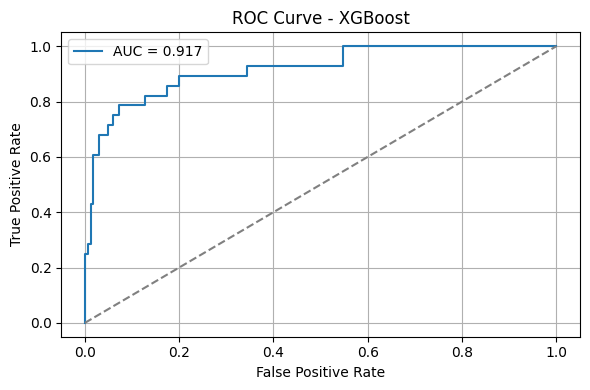

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


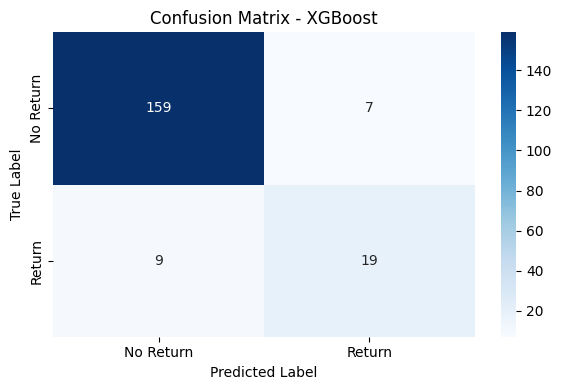

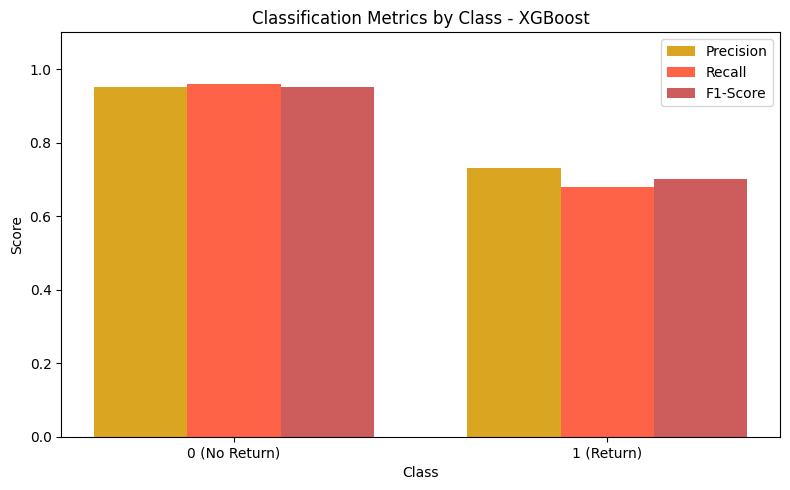

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# === Confusion matrix values (from your XGBoost result) ===
conf_matrix_xgb = np.array([[159, 7],
                            [9, 19]])

# === Classification metrics ===
xgb_metrics = {
    "Class": ["0 (No Return)", "1 (Return)"],
    "Precision": [0.95, 0.73],
    "Recall": [0.96, 0.68],
    "F1-Score": [0.95, 0.70]
}

# === Plot 1: Confusion Matrix Heatmap ===
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Return", "Return"],
            yticklabels=["No Return", "Return"])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# === Plot 2: Classification Metrics Bar Chart ===
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.25
index = np.arange(len(xgb_metrics["Class"]))

for i, metric in enumerate(["Precision", "Recall", "F1-Score"]):
    ax.bar(index + i * bar_width, xgb_metrics[metric],
           width=bar_width, label=metric,
           color=["goldenrod", "tomato", "indianred"][i])

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics by Class - XGBoost')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(xgb_metrics["Class"])
ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

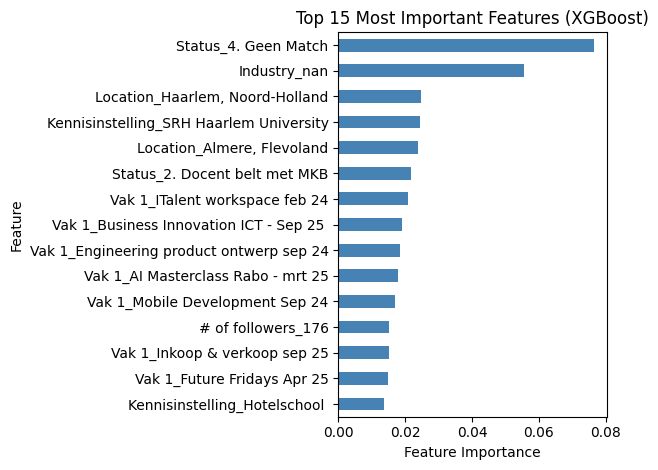

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

encoder = xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names = list(encoder.get_feature_names_out(categorical_cols)) + numeric_cols

importances = xgb_pipeline.named_steps['classifier'].feature_importances_

xgb_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
xgb_imp_df.head(15).plot(
    x='Feature', y='Importance', kind='barh',
    color='steelblue', legend=False
)
plt.title("Top 15 Most Important Features (XGBoost)")
plt.xlabel("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
